## Neural style transfer

Style transfer/ super resolution implementation in pytorch.

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *
from vgg16_avg import VGG16_Avg
from keras import metrics
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.
/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.autograd import Variable
from torch.utils.serialization import load_lua
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets

### Setup

In [3]:
path = 'data/datasets/imagenet/train/'
dpath = path
# dpath = '/data/jhoward/fast/imagenet/sample/'

In [4]:
fnames = glob.glob(path+'**/*.JPEG', recursive=True)
n = len(fnames); n

19439

In [5]:
pickle.dump(fnames, open(dpath+'fnames.pkl', 'wb'))

In [6]:
fnames = pickle.load(open(dpath+'fnames.pkl', 'rb'))
n = len(fnames); n

19439

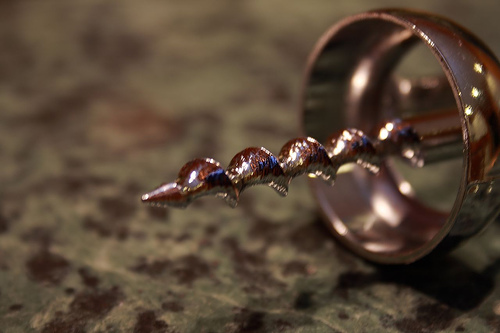

In [7]:
img=Image.open(fnames[55]); img

In [8]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((1,1,1,3))
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [84]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape

In [85]:
# deproc = lambda x: x[:, :, :, ::-1] + rn_mean
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

### Create model

In [11]:
def download_convert_vgg16_model():
    model_url='http://cs.stanford.edu/people/jcjohns/fast-neural-style/models/vgg16.t7'
    file = get_file(model_url, cache_subdir='models')
    vgglua = load_lua(file).parameters()
    vgg = models.VGGFeature()
    for (src, dst) in zip(vgglua[0], vgg.parameters()): dst[:] = src[:]
    torch.save(vgg.state_dict(), dpath+'vgg16_feature.pth')

In [12]:
import torch
from torch.utils.model_zoo import load_url
from torchvision import models

sd = load_url("https://s3-us-west-2.amazonaws.com/jcjohns-models/vgg16-00b39a1b.pth")
sd['classifier.0.weight'] = sd['classifier.1.weight']
sd['classifier.0.bias'] = sd['classifier.1.bias']
del sd['classifier.1.weight']
del sd['classifier.1.bias']

sd['classifier.3.weight'] = sd['classifier.4.weight']
sd['classifier.3.bias'] = sd['classifier.4.bias']
del sd['classifier.4.weight']
del sd['classifier.4.bias']

file_path = path+'models/'+"vgg19-d01eb7cb.pth"
torch.save(sd, file_path)

In [13]:
vgg = models.vgg.vgg16()
vgg.load_state_dict(torch.load(file_path))
optimizer = optim.Adam(vgg.parameters())

In [14]:
vgg.cuda();

In [15]:
arr_lr = bcolz.open(dpath+'trn_resized_72.bc')[:]
arr_hr = bcolz.open(dpath+'trn_resized_288.bc')[:]

In [16]:
arr = bcolz.open(dpath+'trn_resized.bc')[:]

FileNotFoundError: [Errno 2] No such file or directory: 'data/datasets/imagenet/train/trn_resized.bc/meta/sizes'

In [71]:
# arr = torch.from_numpy(arr_hr)
arr = arr_hr
x = K.variable(arr[0])
y = model(x)

IndexError: list index out of range

In [68]:
x = Variable(arr[0])
y = model(x)

AttributeError: module 'keras.backend' has no attribute 'Variable'

In [19]:
url = 'http://www.platform.ai/models/'
fname = 'imagenet_class_index.json'
fpath = get_file(fname, url+fname, cache_subdir='models')

In [20]:
class ResidualBlock(nn.Module):
    def __init__(self, num):
        super(ResidualBlock, self).__init__()
        self.c1 = nn.Conv2d(num, num, kernel_size=3, stride=1, padding=1)
        self.c2 = nn.Conv2d(num, num, kernel_size=3, stride=1, padding=1)
        self.b1 = nn.BatchNorm2d(num)
        self.b2 = nn.BatchNorm2d(num)

    def forward(self, x):
        h = F.relu(self.b1(self.c1(x)))
        h = self.b2(self.c2(h))
        return h + x

In [21]:
class FastStyleNet(nn.Module):
    def __init__(self):
        super(FastStyleNet, self).__init__()
        self.cs = [nn.Conv2d(3, 32, kernel_size=9, stride=1, padding=4)
            ,nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
            ,nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)]
        self.b1s = [nn.BatchNorm2d(i) for i in [32, 64, 128]]
        self.rs = [ResidualBlock(128) for i in range(5)]
        self.ds [nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
            ,nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)]
        self.b2s = [nn.BatchNorm2d(i) for i in [64, 32]]
        self.d3 = nn.Conv2d(32, 3, kernel_size=9, stride=1, padding=4)

    def forward(self, h):
        for i in range(3): h = F.relu(self.b1s[i](self.cs[i](x)))
        for r in self.rs: h = r(h)
        for i in range(2): h = F.relu(self.b2s[i](self.ds[i](x)))
        return self.d3(h)

### Loss functions and processing

In [22]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    return features.bmm(features.transpose(1, 2)) / (ch * h * w)

In [23]:
def vgg_preprocessing(batch):
    tensortype = type(batch.data)
    mean = tensortype(batch.data.size())
    mean[:, 0, :, :] = 103.939
    mean[:, 1, :, :] = 116.779
    mean[:, 2, :, :] = 123.680
    batch -= Variable(mean)

In [24]:
def save_model(model, filename):
    state = model.state_dict()
    for key in state: state[key] = state[key].clone().cpu()
    torch.save(state, filename)

In [25]:
def tensor_save_rgbimage(tensor, filename):
    img = tensor.clone().cpu().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype('uint8')
    img = Image.fromarray(img)
    img.save(filename)

In [26]:
def tensor_save_bgrimage(tensor, filename):
    (b, g, r) = torch.chunk(tensor, 3)
    tensor = torch.cat((r, g, b))
    tensor_save_rgbimage(tensor, filename)

In [27]:
def tensor_load_rgbimage(filename, size=None):
    img = Image.open(filename)
    if size is not None: img = img.resize((size, size), Image.ANTIALIAS)
    img = np.array(img).transpose(2, 0, 1)
    img = torch.from_numpy(img).float()
    return img

In [28]:
def batch_rgb_to_bgr(batch):
    batch = batch.transpose(0, 1)
    (r, g, b) = torch.chunk(batch, 3)
    batch = torch.cat((b, g, r))
    batch = batch.transpose(0, 1)
    return batch

In [29]:
def batch_bgr_to_rgb(batch):
    return batch_rgb_to_bgr(batch)

### Recreate input

In [86]:
base = K.variable(img_arr)
gen_img = K.placeholder(shp)
batch = K.concatenate([base, gen_img],0)

In [87]:
model = VGG16_Avg(input_tensor=batch, include_top=False)

In [88]:
outputs = {l.name: l.output for l in model.layers}

In [89]:
layer = outputs['block5_conv1']

In [90]:
class Evaluator(object):
    def __init__(self, f, shp): 
        self.f = f
        self.shp = shp
        
    def loss(self, x):
        loss_, grads_ = self.f([x.reshape(self.shp)])
        self.grad_values = grads_.flatten().astype(np.float64)
        return loss_.astype(np.float64)

    def grads(self, x): return np.copy(self.grad_values)

In [91]:
content_loss = lambda base, gen: metrics.mse(gen, base)
loss = content_loss(layer[0], layer[1])
grads = K.gradients(loss, gen_img)
fn = K.function([gen_img], [loss]+grads)

In [92]:
evaluator = Evaluator(fn, shp)

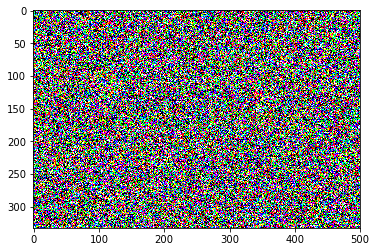

In [94]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
plt.imshow(rand_img(shp)[0])

In [95]:
rand_img(shp).shape

(1, 333, 500, 3)

In [96]:
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', np.sum(min_val))
#         print('Current loss value:', min_val)
        plt.imsave(f'{path}res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
    return x

In [97]:
iterations=10
x = rand_img(shp)

In [98]:
x = solve_image(evaluator, iterations, x)

Current loss value: 51764.7828674
Current loss value: 51764.7826743
Current loss value: 51764.7827725
Current loss value: 51764.7828031
Current loss value: 51764.7827339
Current loss value: 51764.7815499
Current loss value: 51764.7816768
Current loss value: 51764.7820277
Current loss value: 51764.7815294
Current loss value: 51764.7817588


conv 1 of last block (5)

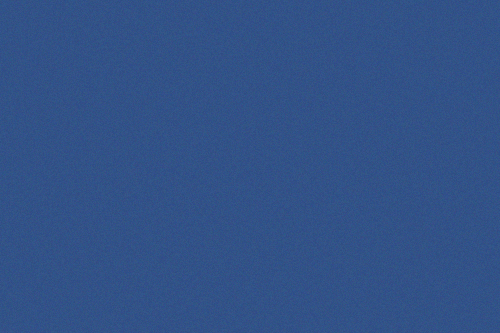

In [79]:
Image.open(path + 'res_at_iteration_9.png')

conv 1 of 4th block

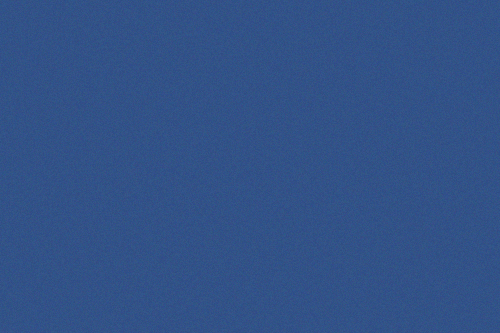

In [80]:
Image.open(path + 'res_at_iteration_9.png')

### Recreate style

In [99]:
def plot_arr(arr): plt.imshow(deproc(arr,arr.shape)[0].astype('uint8'))

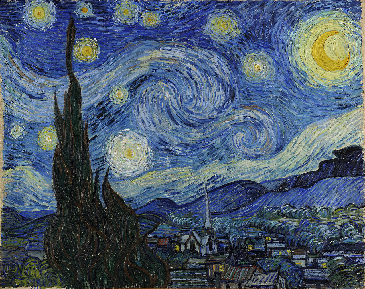

In [100]:
style = Image.open('data/starry_night.jpg')
style = style.resize(np.divide(style.size,3.5).astype('int32')); style

In [ ]:
style = Image.open('data/bird.jpg')
style = style.resize(np.divide(style.size,2.4).astype('int32')); style

In [ ]:
style = Image.open('data/simpsons.jpg')
style = style.resize(np.divide(style.size,2.7).astype('int32')); style

In [101]:
w,h = style.size

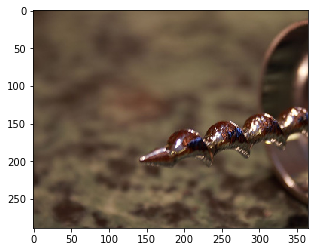

In [102]:
src = img_arr[:,:h,:w]
shp = src.shape
style_arr = preproc(np.expand_dims(style,0)[:,:,:,:3])
plot_arr(src)

In [103]:
base = K.variable(style_arr)
gen_img = K.placeholder(shp)
batch = K.concatenate([base, gen_img],0)

In [104]:
model = VGG16_Avg(input_tensor=batch, include_top=False)
outputs = {l.name: l.output for l in model.layers}

In [105]:
layers = [outputs['block{}_conv1'.format(o)] for o in range(1,4)]

In [106]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [107]:
def style_loss(x, targ):
    return keras.metrics.mse(gram_matrix(x), gram_matrix(targ))

In [108]:
loss = sum(style_loss(l[0], l[1]) for l in layers)
grads = K.gradients(loss, gen_img)
style_fn = K.function([gen_img], [loss]+grads)

In [109]:
evaluator = Evaluator(style_fn, shp)

In [110]:
iterations=10
x = rand_img(shp)

In [111]:
x = solve_image(evaluator, iterations, x)

InvalidArgumentError: Incompatible shapes: [64] vs. [128]
	 [[Node: add_1 = Add[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](add, Mean_3)]]
	 [[Node: add_2/_401 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_812_add_2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'add_1', defined at:
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-108-3c786dec49a8>", line 1, in <module>
    loss = sum(style_loss(l[0], l[1]) for l in layers)
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 865, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 80, in add
    result = _op_def_lib.apply_op("Add", x=x, y=y, name=name)
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Incompatible shapes: [64] vs. [128]
	 [[Node: add_1 = Add[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](add, Mean_3)]]
	 [[Node: add_2/_401 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_812_add_2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [ ]:
Image.open(path + 'res_at_iteration_9.png')

In [ ]:
Image.open(path + 'res_at_iteration_9.png')

### Style transfer

In [ ]:
def total_variation_loss(x, r, c):
    assert K.ndim(x) == 3
    a = K.square(x[:r - 1, :c - 1, :] - x[1:, :c - 1, :])
    b = K.square(x[:r - 1, :c - 1, :] - x[:r - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [ ]:
base = K.variable(src)
style_v = K.variable(style_arr)
gen_img = K.placeholder(shp)
batch = K.concatenate([base, style_v, gen_img],0)

In [ ]:
model = VGG16_Avg(input_tensor=batch, include_top=False)
outputs = {l.name: l.output for l in model.layers}

In [ ]:
style_layers = [outputs['block{}_conv1'.format(o)] for o in range(1,6)]

In [ ]:
content_name = 'block4_conv2'

In [ ]:
content_layer = outputs[content_name]

In [ ]:
input_layer = model.layers[0].output

In [ ]:
loss = sum(style_loss(l[1], l[2]) for l in style_layers)
loss += content_loss(content_layer[0], content_layer[2])/10.
# loss += total_variation_loss(input_layer[2], h, w)/1e9
grads = K.gradients(loss, gen_img)
transfer_fn = K.function([gen_img], [loss]+grads)

In [ ]:
evaluator = Evaluator(transfer_fn, shp)

In [ ]:
iterations=10
x = rand_img(shp)/10.

In [ ]:
x = solve_image(evaluator, iterations, x)

In [ ]:
Image.open(path + 'res_at_iteration_9.png')

In [ ]:
Image.open(path + 'res_at_iteration_9.png')

In [ ]:
Image.open(path + 'res_at_iteration_9.png')

## Perceptual loss for Van Gogh

In [ ]:
inp_shape = (72,72,3)
inp = Input(inp_shape)

In [ ]:
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)
        
    def get_output_shape_for(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

In [ ]:
ref_model = Model(inp, ReflectionPadding2D((60,20))(inp))
ref_model.compile('adam', 'mse')

In [ ]:
p = ref_model.predict(arr[50:51])

In [ ]:
plt.imshow(p[0].astype('uint8'))

In [ ]:
def conv_block(x, filters, size, stride=(2,2), mode='same'):
    x = Convolution2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization(axis=1, mode=2)(x)
    return Activation('relu')(x)

In [ ]:
def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = Convolution2D(nf, 3, 3, border_mode='same')(x)
    x = BatchNormalization(axis=1, mode=2)(x)
#     ip = Lambda(lambda x: x[:, 2:-2, 2:-2])(ip)
    return merge([x, ip], mode='sum')

In [ ]:
def deconv_block(x, filters, size, shape, stride=(2,2)):
    x = Deconvolution2D(filters, size, size, subsample=stride, border_mode='same',
                        output_shape=(None,)+shape)(x)
    x = BatchNormalization(axis=1, mode=2)(x)
    return Activation('relu')(x)

In [ ]:
parms = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

In [ ]:
inp=Input(inp_shape)
# x=ReflectionPadding2D((40, 40))(inp)
x=conv_block(inp, 64, 9, (1,1))
# x=conv_block(x, 64, 3)
# x=conv_block(x, 128, 3)
for i in range(4): x=res_block(x)
x=deconv_block(x, 64, 3, (144, 144, 64))
x=deconv_block(x, 64, 3, (288, 288, 64))
x=Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
outp=Lambda(lambda x: (x+1)*127.5)(x)

In [ ]:
vgg_l = Lambda(preproc)
outp_l = vgg_l(outp)

In [ ]:
out_shape = (288,288,3)
vgg_inp=Input(out_shape)
vgg= VGG16(include_top=False, input_tensor=vgg_l(vgg_inp))
for l in vgg.layers: l.trainable=False

In [ ]:
vgg_content = Model(vgg_inp, vgg.get_layer('block2_conv2').output)
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

In [ ]:
loss = Lambda(lambda x: K.sqrt(K.mean((x[0]-x[1])**2, (1,2))))([vgg1, vgg2])
m_final = Model([inp, vgg_inp], loss)
targ = np.zeros((arr.shape[0], 128))

In [ ]:
m_final.compile('adam', 'mse')

In [ ]:
m_final.evaluate([arr_lr[:10],arr_hr[:10]], targ[:10])

In [ ]:
K.set_value(m_final.optimizer.lr, 1e-3)

In [ ]:
m_final.fit([arr_lr, arr_hr], targ, 8, 2, **parms)

In [ ]:
K.set_value(m_final.optimizer.lr, 1e-4)

In [ ]:
m_final.fit([arr_lr, arr_hr], targ, 16, 2, **parms)

In [ ]:
m_final.save_weights(dpath+'m_final.h5')

In [ ]:
top_model = Model(inp, outp)

In [ ]:
top_model.save_weights(dpath+'top_final.h5')

In [ ]:
p = top_model.predict(arr_lr[:20])

In [ ]:
plt.imshow(arr_lr[10].astype('uint8'));

In [ ]:
plt.imshow(p[10].astype('uint8'))

In [ ]:
plt.imshow(arr_hr[0].astype('uint8'));

### End